# Introduction

The following cells should contain all already completed steps to obtain the leading eigenvalue from the linearized Eliashberg equations through the particle-particle vertex when obtained from lDGA.

All unverified (yet yto be tested) and potentially unimplemented parts are described in the comments.


# Setup

## Packages

The following steps are automatically executed in one of the following cells.

You need the following source codes:

    - https://github.com/atomtomate/VertexPostprocessing.jl
    - https://github.com/atomtomate/LadderDGA.jl

In order to install these packages without dependency issues, first add my private registry with

```
using Pkg
pkg"registry add https://github.com/Atomtomate/JuliaRegistry.git"
```

Some Julia versions and operating systems experience problems with SSL certificates. A temporary workaround is to immediately after starting Julia, set the `ENV` variables 

```
ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""
ENV["JULIA_SSL_NO_VERIFY_HOSTS"] = "github.com"
```

It is also sometimes necessary to delete the `Manifest.toml` in custom repositories.

The following general Julia packages are required for this notebook:

    - CairoMakie, LaTeXStrings, JLD2


## Data

We need the 2 particle GF in the form of the `2_part_gf_red` file as obtained from the new version of the Fortran code (<mark>you could try and rewrite the script to work with the `vert_chi` file; I have not tried that</mark>).

To expand this file, we need the `freqList.jld2` generated for this calculation (see `EquivalenceClassesConstructor.jl`).

<mark>In order to rule out errors in the index mappings, all results below should be calculated for two sets of inputs: shifted and non-shifted.</mark>

<mark>Gamma is saved WITHOUT the 1/beta^2 factor!</mark>


## Settings

Below, set:

    - dbgPkg to `true` if you have trouble with the package manager or not added my private registry.
    - `codeDir` variable to a directory that contains the LadderDGA.jl and VertexPostprocessing.jl codes (they have to be instantiated, as usual).
    - `dataDir` variable containing the `2_part_gf_red` files

In [1]:
codeDir = "G:/Codes/"
dataDir = "G:/Hamburg/b08.0_mu0.9/"
#dataDir = "G:/Hamburg/compressibility/b44.0U2.64_mu1.59_large"
dbgPkg = true

using Pkg
if dbgPkg
    ENV["JULIA_SSL_CA_ROOTS_PATH"] = ""
    ENV["JULIA_SSL_NO_VERIFY_HOSTS"] = "github.com"
    pkg"registry add https://github.com/Atomtomate/JuliaRegistry.git"
end

     Cloning registry from "https://github.com/Atomtomate/JuliaRegistry.git"
Registry `JuliaRegistry` already exists in `C:\Users\Atomt\.julia\registries\JuliaRegistry`.


In [25]:
Pkg.activate("")
#Pkg.add(["CairoMakie", "LaTeXStrings", "JLD2"])
using CairoMakie, LaTeXStrings
using GeometryBasics
using Plots
using JLD2

Pkg.activate(joinpath(codeDir,"VertexPostprocessing.jl/"))
#Pkg.instantiate()
using VertexPostprocessing

Pkg.activate(joinpath(codeDir,"LadderDGA.jl"))
#Pkg.instantiate()
using LadderDGA

  Activating project at `G:\Codes\LadderDGA.jl\notebooks`
  Activating project at `G:\Codes\VertexPostprocessing.jl`
  Activating project at `G:\Codes\LadderDGA.jl`


# Expand Vertex

## Introduction

This part of the code is responsible for generating the input for lDGA from the `2_part_gf_red` using index mappings and the local BSE.
<mark>Check that the quantities are generated correctly, as an example the asymptotic behavior is investigated below.</mark>

We use the `expand_vertex.jl` script from `VertexPostprocessing.jl`. 
All potential fixes should be done in the corresponding routines of that package.
Adjust the `legacy_mode` (`true` when reading the `vert_chi` instead `2_part_gf_red`) and `fname` variables according to the test you are running.

More details can be found in the `expand_pp_test` notebook of the `VertexPostprocessing.jl` project, which we execute now.

In [26]:
legacy_mode = "false"
ofname = "DMFT2_out.jld2"

empty!(ARGS)
push!(ARGS, joinpath(dataDir))
push!(ARGS, dataDir)
push!(ARGS, legacy_mode)
push!(ARGS, ofname)

4-element Vector{String}:
 "G:/Hamburg/b08.0_mu0.9/"
 "G:/Hamburg/b08.0_mu0.9/"
 "false"
 "DMFT2_out.jld2"

In [31]:
include(joinpath(codeDir,"VertexPostprocessing.jl", "scripts", "expand_vertex.jl"))

Expanding Vertex


  Activating project at `G:\Codes\VertexPostprocessing.jl`


LoadError: LoadError: BoundsError: attempt to access 1012650-element Vector{ComplexF64} at index [1971268]
in expression starting at G:\Codes\VertexPostprocessing.jl\scripts\expand_vertex_no_save.jl:12
in expression starting at G:\Codes\VertexPostprocessing.jl\scripts\expand_vertex.jl:39

## Construction from chipp


<mark>The 1/4 factor for the particle-particle susceptibility is not absorbed in the calculations. This also results in a missing factor of 1/2 in the bare bubble for the pp-channel! Check the code for details.</mark>

The first construction method uses:

0. I/O from vert_chi and 2_part_gf_red. This is important because of conventions with subtraction terms!

    0.a vert_chi: Columns 4+5 are real and imaginary parts of $\chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\uparrow}$, columns 6+7 are real and imaginary parts of $\chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\downarrow}$

   0.a 2_part_gf_red: Columns 4+5 are real and imaginary parts of $\chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\uparrow} + \chi^{\nu\nu'\omega}_{\mathrm{ph},0}$, columns 6+7 are real and imaginary parts of $\chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\downarrow} + \chi^{\nu\nu'\omega}_{\mathrm{ph},0}$

2. Bare Susceptibility

    1.a  $\chi^{\nu\nu'\omega}_{\mathrm{ph},0} = - \beta \delta_{\nu\nu'} G^{\nu} G^{\omega + \nu}$
 
    1.b  $\chi^{\nu\nu'\omega}_{\mathrm{pp},0} = - \beta \delta_{\nu\nu'} G^{\nu} G^{\omega - \nu}$
     
3. Susceptibility

    2.a (Optional, mapping from ph to pp channel: $\chi^{\nu_{\mathrm{pp}}\nu'_{\mathrm{pp}}\omega_{\mathrm{pp}}}_{\mathrm{pp},\sigma\sigma'} = \chi^{\nu_\mathrm{ph}\nu_\mathrm{ph}'\omega_\mathrm{ph}}_{\mathrm{ph},\sigma\sigma'} $

    with    $\nu_{\mathrm{pp}} = \nu_{\mathrm{ph}},\nu'_{\mathrm{pp}} = \nu'_{\mathrm{ph}},\omega_{\mathrm{pp}} = \omega_{\mathrm{ph}} - \nu_{\mathrm{ph}} - \nu'_{\mathrm{ph}}$

    2.b $\chi^{\nu\nu'\omega}_{\mathrm{m}} = \chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\uparrow} - \chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\downarrow}$

    2.c $\chi^{\nu\nu'\omega}_{\mathrm{d}} = \chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\uparrow} + \chi^{\nu\nu'\omega}_{\mathrm{ph},\uparrow\downarrow}$

    2.d $4 \chi^{\nu\nu'\omega}_{\mathrm{s}} = 2\chi^{\nu\nu'\omega}_{\mathrm{pp},\uparrow\downarrow} - \chi^{\nu\nu'\omega}_{\mathrm{pp},\uparrow\uparrow} - \chi^{\nu\nu'\omega}_{\mathrm{pp},0}$

    2.e $4 \chi^{\nu\nu'\omega}_{\mathrm{t}} = \chi^{\nu\nu'\omega}_{\mathrm{pp},\uparrow\uparrow} + \chi^{\nu\nu'\omega}_{\mathrm{pp},0}$

5. Full Vertex 

    4.a  $F^{\nu\nu'\omega}_{r} = - \frac{\chi^{\nu\nu'\omega}_{r} - \chi^{\nu\nu'\omega}_{\mathrm{r},0}}{\chi^{\nu\nu\omega}_{r,0} \chi^{\nu'\nu'\omega}_{\mathrm{r},0}}$ for $r \in \{ \mathrm{m}, \mathrm{d},\mathrm{t}\}$

    4.b  $F^{\nu\nu'\omega}_{\mathrm{s}} = - \frac{\chi^{\nu\nu'\omega}_{\mathrm{s}} + \chi^{\nu\nu'\omega}_{\mathrm{r},0}}{\chi^{\nu\nu\omega}_{r,0} \chi^{\nu'\nu'\omega}_{\mathrm{r},0}}$ 

6. Irreducible Vertex $\Gamma$

    6.b $\Gamma^{\nu\nu'\omega}_{\mathrm{m}} = \left[{\chi^{\nu\nu'\omega}_{\mathrm{m}}}\right]^{-1} - \frac{\delta_{\nu\nu'}}{\chi^{\nu\nu\omega}_{\mathrm{ph},0}}$

    6.c $\Gamma^{\nu\nu'\omega}_{\mathrm{d}} = \left[{\chi^{\nu\nu'\omega}_{\mathrm{d}}}\right]^{-1} - \frac{\delta_{\nu\nu'}}{\chi^{\nu\nu\omega}_{\mathrm{ph},0}}$

    6.d  $\Gamma^{\nu\nu'\omega}_{\mathrm{s}} = \left[{\chi^{\nu\nu'\omega}_{\mathrm{s}}}\right]^{-1} + \frac{2 \delta_{\nu\nu'}}{\chi^{\nu\nu\omega}_{\mathrm{pp},0}}$

    6.e  $\Gamma^{\nu\nu'\omega}_{\mathrm{t}} = \left[{\chi^{\nu\nu'\omega}_{\mathrm{t}}}\right]^{-1} - \frac{2 \delta_{\nu\nu'}}{\chi^{\nu\nu\omega}_{\mathrm{pp},0}}$


7. Reducible Vertex $\Phi^{\nu\nu'\omega}_{\mathrm{pp}/\mathrm{ph}} = F^{\nu\nu'\omega}_{\mathrm{pp}/\mathrm{ph}} - \Gamma^{\nu\nu'\omega}_{\mathrm{pp}/\mathrm{ph}}$



<!--- 8. backup $ \chi^{\nu\nu'(\nu-\nu')}_{\mathrm{pp},\sigma\sigma'} = \chi^{\nu\nu'\omega}_{\mathrm{ph},\sigma\sigma'}$ -->


In [28]:
# ========== Parameters ==========
freqListFile = joinpath(dataDir,"freqList.jld2")
legacy_mode  = false
ofname = "DMFT_test_out.jld2"

# ========== I/O and expand ==========
println("Expanding Vertex")
fname = legacy_mode ? "vert_chi" : "2_part_gf_red"
nBose, nFermi, shift, freqList, TwoPartGF_upup, TwoPartGF_updo = expand_2PtGF_CSV(freqListFile, joinpath(dataDir, fname))
println("Done expanding!")

println("Calculating single particle Green's function")
U, β, p, νnGrid, G0W, GImp, ΣImp, μ, nden = restore_1pt_GF(joinpath(dataDir, "config.toml"), joinpath(dataDir, "hubb.andpar"); nFreq=2000)
gLoc = nothing
println("mu = $μ, U= $U, beta = $β, nden = $nden")
println("andpar: \n $p")
E_kin_DMFT = calc_EKin_DMFT(νnGrid[0:end], p.ϵₖ, p.Vₖ, GImp[0:end], nden, U, β, μ)
E_pot_DMFT = calc_EPot_DMFT(νnGrid[0:end], p.ϵₖ, p.Vₖ, GImp[0:end], nden, U, β, μ)

res = isfile(joinpath(dataDir, "chi_asympt")) ? read_chi_asympt(joinpath(dataDir, "chi_asympt")) : error("chi_asympt not found!")
_, χ_d_asympt, χ_m_asympt, χ_pp_asympt = res

# ========== Transformations ==========
println("Calculating derived quantities. Rank 3 quantities have the index convention [ωm, νn, νpn]")
χ_upup, χ_updo = if legacy_mode
    TwoPartGF_upup, TwoPartGF_updo
else
    G2_to_χ(freqList, TwoPartGF_upup, GImp, β), G2_to_χ(freqList, TwoPartGF_updo, GImp, β)
end


χ0_full = compute_χ0(-nBose:nBose, -(nFermi+2*nBose):(nFermi+2*nBose)-1, GImp, β; mode=:ph)
χ0_pp_full   = compute_χ0(-nBose:nBose, -(nFermi+2*nBose):(nFermi+2*nBose)-1, GImp, β; mode=:pp);

χm, χd = uu_ud_TO_m_d(χ_upup, χ_updo)
χs, χt = χph_to_χpp(freqList, χ_upup, χ_updo, χ0_pp_full, shift, nBose, nFermi);

Expanding Vertex


LoadError: BoundsError: attempt to access 1012650-element Vector{ComplexF64} at index [1971268]

In [29]:
# Test of the function Freq_to_OneToIndex. This function should map Matsubara indices to array indices (including shift)
ωm_t = 2; νn_t = -1; νpn_t = 2;
ωi_t,νi_t,νpi_t =  VertexPostprocessing.Freq_to_OneToIndex(ωm_t, νn_t, νpn_t, shift, nBose, nFermi)
freqList_t = reshape_lin_to_rank3(freqList,nBose,nFermi);
all((ωm_t,νn_t,νpn_t) .== freqList_t[ωi_t,νi_t,νpi_t])

LoadError: UndefVarError: `shift` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Graphics in the current active module Main

In [30]:
display(L"\chi^{\nu_0\omega_0}_{\mathrm{ph},0} = \chi^{\nu_0\omega_1}_{\mathrm{pp},0}: ")
println(χ0_full[0,0] ≈ χ0_pp_full[1, 0])
χs_t = reshape_lin_to_rank3(χs,nBose,nFermi);
χs_t[isnan.(χs_t)] .= 0.0
χs_ω = dropdims(sum(χs_t,dims=(2,3)), dims=(2,3)) ./ β^2;
χt_t = reshape_lin_to_rank3(χt,nBose,nFermi);
χt_t[isnan.(χt_t)] .= 0.0
χt_ω = dropdims(sum(χt_t,dims=(2,3)), dims=(2,3)) ./ β^2;
p1 = Plots.plot(-nBose:nBose, real(χs_ω), markershape=:auto, markersize=2, label=L"\chi^{\omega}_{\mathrm{s}}", xlims=(-100,100), ylabel=L"\mathrm{Re}[\chi]")
Plots.plot!(-nBose:nBose, real(χt_ω), markershape=:auto, markersize=2, label=L"\chi^{\omega}_{\mathrm{t}}")
Plots.plot!(0:length(χ_pp_asympt)-1, 2 .* real(χ_pp_asympt/β^2), markershape=:auto, markersize=2)
p2 = Plots.plot(-nBose:nBose, imag(χs_ω), markershape=:auto, markersize=2, label=L"\chi^{\omega}_{\mathrm{s}}", xlims=(-100,100), ylabel=L"\mathrm{Im}[\chi]")
Plots.plot!(-nBose:nBose, imag(χt_ω), markershape=:auto, markersize=2, label=L"\chi^{\omega}_{\mathrm{t}}")
Plots.plot!(0:length(χ_pp_asympt)-1, 2 .* imag(χ_pp_asympt/β^2), markershape=:auto, markersize=2, label=L"\chi_{\mathrm{asympt}}")
p = Plots.plot(p1,p2, size=(1000,400))
savefig("chi_asympt_pl.pdf")
display(p)

L"$\chi^{\nu_0\omega_0}_{\mathrm{ph},0} = \chi^{\nu_0\omega_1}_{\mathrm{pp},0}: $"

LoadError: UndefVarError: `χ0_full` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [8]:
# ========== Local BSE ==========
#   This is implemented in GFTools.jl in VertexPostprocessing.jl/src
Fm = VertexPostprocessing.F_from_χ(:m, χm, χ0_full, β, shift, nBose, nFermi)
Fd = VertexPostprocessing.F_from_χ(:d, χd, χ0_full, β, shift, nBose, nFermi)
Γm = computeΓ_ph(freqList, χm, χ0_full, nBose, nFermi)
Γd = computeΓ_ph(freqList, χd, χ0_full, nBose, nFermi)
χm_loc = reshape_lin_to_rank3(χm,nBose,nFermi)
χd_loc = reshape_lin_to_rank3(χd,nBose,nFermi)
println("Done with ph channel!")

LoadError: UndefVarError: `χm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [9]:
χuu, χup = m_d_TO_uu_ud(χm, χd)
Fuu = VertexPostprocessing.F_from_χ(:m, χuu, χ0_full, β, shift, nBose, nFermi)
Fud = VertexPostprocessing.F_from_χ(:d, χup, χ0_full, β, shift, nBose, nFermi);

LoadError: UndefVarError: `χm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [10]:
Plots.heatmap(real(Γm[151,97:end-96,97:end-96]))

LoadError: UndefVarError: `Γm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [11]:
Plots.heatmap(real(Γd[151,97:end-96,97:end-96] .- U / β^2 ))

LoadError: UndefVarError: `Γd` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [12]:
Plots.heatmap(real(Γs[151,97:end-96,97:end-96]))

LoadError: UndefVarError: `Γs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
Plots.heatmap(real(Γt[151,97:end-96,97:end-96]))

LoadError: UndefVarError: `Γt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [14]:
Γs, Γt       = computeΓ_pp(freqList, χs, χt, χ0_pp_full, nBose, nFermi);

LoadError: UndefVarError: `freqList` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [15]:
freqList_t = reshape_lin_to_rank3(freqList,nBose,nFermi)
freqList_t[149,:,:];
χs_t = reshape_lin_to_rank3(χs,nBose,nFermi);

LoadError: UndefVarError: `freqList` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [16]:
Fs = VertexPostprocessing.F_from_χ(:s, reshape_lin_to_rank3(χs,nBose,nFermi), χ0_pp_full, β, shift, nBose, nFermi);
Ft = VertexPostprocessing.F_from_χ(:t, reshape_lin_to_rank3(χt,nBose,nFermi), χ0_pp_full, β, shift, nBose, nFermi);

LoadError: UndefVarError: `χs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Construction of Fpp

The notebook `Test_F_ladder_pp.ipynb` has details and tests for the functions that are used to construct Φs and Φt.


## Asymptotic Behavior

The asymptotic behavior is given here, the variables for diagonal and background are defined in the next cell.

### $\Gamma$ 

$\Gamma^{\nu\nu'\omega}_d \sim \phantom{-}U + \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2 }\chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp,\uparrow\downarrow} $

$\Gamma^{\nu\nu'\omega}_m \sim -U + \frac{U^2}{2} \chi^{\nu'-\nu}_d - \frac{U^2}{2} \chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp,\uparrow\downarrow} $

$\Gamma^{\nu\nu'\omega}_s \sim 2U - \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{3U^2}{2} \chi^{\omega-\nu-\nu'}_{m} $

$\Gamma^{\nu\nu'\omega}_t \sim \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_{m} $

### $F$

$F^{\nu\nu'\omega}_d \sim \phantom{-}U + \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2 }\chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp} + U \lambda^{\nu\omega}_d + U \lambda^{\nu'\omega}_d + U^2 \chi^{\omega}_d$

$F^{\nu\nu'\omega}_m \sim -U + \frac{U^2}{2} \chi^{\nu'-\nu}_d - \frac{U^2}{2} \chi^{\nu'-\nu}_m - U^2 \chi^{\nu+\nu'+\omega}_{pp}  + U \lambda^{\nu\omega}_m + U \lambda^{\nu'\omega}_m + U^2 \chi^{\omega}_m$

$F^{\nu\nu'\omega}_s \sim 2U - \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{3U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{3U^2}{2} \chi^{\omega-\nu-\nu'}_{m} + 2U \lambda^{\nu\omega}_{pp,\uparrow\downarrow} + 2U \lambda^{\nu'\omega}_{pp,\uparrow\downarrow} + 2 U^2 \chi^{\omega}_{pp,\uparrow\downarrow}$

$F^{\nu\nu'\omega}_t \sim  \frac{U^2}{2} \chi^{\nu'-\nu}_d + \frac{U^2}{2} \chi^{\nu'-\nu}_m - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_d - \frac{U^2}{2} \chi^{\omega-\nu-\nu'}_{m}$


In [17]:
# Parameters 
ωn = 0
ωi0 = nBose+ωn+1;
bg_ind = floor(Int, size(Fd,2)*(1.4/4))
bg_offset = 5
nan_ind = trunc(Int,nBose/2+8);

LoadError: UndefVarError: `nBose` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
# Print function
function format_out(val, lim; digits=5)
    lim_s = lpad(rpad(round(real(lim),digits=digits), 6, "0"),10, " ")
    val_s = lpad(rpad(round(real(val),digits=digits), 6, "0"),10, " ")
    sim = (isapprox(val, lim, rtol=0.05) || (abs(val) < 0.1 && abs(lim) < 0.1 )) ? "\e[1m\e[38;2;0;150;50;249m✓\x1b[0m" :  "\e[1m\e[38;2;250;0;0;249m↯\x1b[0m"
    return "$val_s ≟ $lim_s  " * sim
end


# Definitions

Γd_lim_diag  =  U + 0.5 * U^2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 
Γm_lim_diag  = -U + 0.5 * U^2 * χ_d_asympt[1]/β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2 
Γs_lim_diag  = 2U - 0.5 * U^2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2
Γt_lim_diag  =  0 + 0.5 * U^2 * χ_d_asympt[1]/β^2 + 0.5 * U^2 * χ_m_asympt[1]/β^2;

Γd_lim_adiag =  U - 1.0 * U^2 * χ_pp_asympt[1]/β^2 
Γm_lim_adiag = -U + 1.0 * U^2 * χ_pp_asympt[1]/β^2  
Γs_lim_adiag = 2U - 0.5 * U^2 * χ_d_asympt[1] /β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2
Γt_lim_adiag =  0 - 0.5 * U^2 * χ_d_asympt[1] /β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2;

Γd_lim_bg =  U
Γm_lim_bg = -U
Γs_lim_bg = 2U
Γt_lim_bg = 0.0;

Fd_lim_diag =  U + U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 - 1 * U^2 * χ_d_asympt[1]/β^2
Fm_lim_diag = -U + U^2/2 * χ_d_asympt[1]/β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2 - 1 * U^2 * χ_m_asympt[1]/β^2
Fs_lim_diag = 2U - U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 - 2 * U^2 * χ_pp_asympt[1]/β^2
Ft_lim_diag =      U^2/2 * χ_d_asympt[1]/β^2 + 0.5 * U^2 * χ_m_asympt[1]/β^2 ;

Fd_lim_adiag =  U - U^2 * χ_pp_asympt[1]/β^2 - 1 * U^2 * χ_d_asympt[1]/β^2
Fm_lim_adiag = -U + U^2 * χ_pp_asympt[1]/β^2 - 1 * U^2 * χ_m_asympt[1]/β^2
Fs_lim_adiag = 2U - U^2/2 * χ_d_asympt[1]/β^2 + 1.5 * U^2 * χ_m_asympt[1]/β^2 - 2 * U^2 * χ_pp_asympt[1]/β^2
Ft_lim_adiag =    - U^2/2 * χ_d_asympt[1]/β^2 - 0.5 * U^2 * χ_m_asympt[1]/β^2 ;

Fd_lim_bg =  U - 1 * U^2 * χ_d_asympt[1]/β^2 
Fm_lim_bg = -U - 1 * U^2 * χ_m_asympt[1]/β^2 
Fs_lim_bg = 2U - 2 * U^2 * χ_pp_asympt[1]/β^2
Ft_lim_bg = 0.0;


# - compensates global -1 factor in script

println("                   numerical ≟ exact")
println("   ================ Γ ==================   ")
println("Diagonal Γd   :   $(format_out(Γd[ωi0,nan_ind+1,nan_ind+1] .* β^2 , Γd_lim_diag))")
println("Diagonal Γm   :   $(format_out(Γm[ωi0,nan_ind+1,nan_ind+1] .* β^2 , Γm_lim_diag))")
println("Diagonal Γs   :   $(format_out(Γs[ωi0,nan_ind+1,nan_ind+1] .* β^2 , Γs_lim_diag))")
println("Diagonal Γt   :   $(format_out(Γt[ωi0,nan_ind+1,nan_ind+1] .* β^2 , Γt_lim_diag))")

println("Anti-Diagonal Γd   :   $(format_out(Γd[ωi0,nan_ind+1,end-nan_ind] .* β^2, Γd_lim_adiag))")
println("Anti-Diagonal Γm   :   $(format_out(Γm[ωi0,nan_ind+1,end-nan_ind] .* β^2, Γm_lim_adiag))")
println("Anti-Diagonal Γs   :   $(format_out(Γs[ωi0,nan_ind+1,end-nan_ind] .* β^2, Γs_lim_adiag))")
println("Anti-Diagonal Γt   :   $(format_out(Γt[ωi0,nan_ind+1,end-nan_ind] .* β^2, Γt_lim_adiag))")

println("Background Γd :   $(format_out(Γd[ωi0,nan_ind+1,bg_ind+bg_offset] .* β^2, Γd_lim_bg))")
println("Background Γm :   $(format_out(Γm[ωi0,nan_ind+1,bg_ind+bg_offset] .* β^2, Γm_lim_bg))")
println("Background Γs :   $(format_out(Γs[ωi0,nan_ind+1,bg_ind+bg_offset] .* β^2, Γs_lim_bg))")
println("Background Γt :   $(format_out(Γt[ωi0,nan_ind+1,bg_ind+bg_offset] .* β^2, Γt_lim_bg))")

println("   ================ F ==================   ")
println("Diagonal Fd   :   $(format_out(Fd[ωi0,nan_ind+1,nan_ind+1], Fd_lim_diag))")
println("Diagonal Fm   :   $(format_out(Fm[ωi0,nan_ind+1,nan_ind+1], Fm_lim_diag))")
println("Diagonal Fs   :   $(format_out(Fs[ωi0,nan_ind+1,nan_ind+1], Fs_lim_diag))")
println("Diagonal Ft   :   $(format_out(Ft[ωi0,nan_ind+1,nan_ind+1], Ft_lim_diag))")

println("Anti-Diagonal Fd   :   $(format_out(Fd[ωi0,nan_ind+1,end-nan_ind], Fd_lim_adiag))")
println("Anti-Diagonal Fm   :   $(format_out(Fm[ωi0,nan_ind+1,end-nan_ind], Fm_lim_adiag))")
println("Anti-Diagonal Fs   :   $(format_out(Fs[ωi0,nan_ind+1,end-nan_ind], Fs_lim_adiag))")
println("Anti-Diagonal Ft   :   $(format_out(Ft[ωi0,nan_ind+1,end-nan_ind], Ft_lim_adiag))")

println("Background Fd :   $(format_out(Fd[ωi0,nan_ind+1,bg_ind+bg_offset], Fd_lim_bg))")
println("Background Fm :   $(format_out(Fm[ωi0,nan_ind+1,bg_ind+bg_offset], Fm_lim_bg))")
println("Background Fs :   $(format_out(Fs[ωi0,nan_ind+1,bg_ind+bg_offset], Fs_lim_bg))")
println("Background Ft :   $(format_out(Ft[ωi0,nan_ind+1,bg_ind+bg_offset], Ft_lim_bg))")

LoadError: UndefVarError: `U` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [19]:
ft = jldopen("G:/Hamburg/irakli_beta44.0U2.64_mu1.59/DMFT2_out.jld2","r")
ft["nden"]

1.003599834803682

In [20]:
f = Figure()
ax = Axis(f[1, 1],limits=(-80,-60,60,80)) #(nan_ind-nFermi-1,120-nFermi-1,nan_ind-nFermi-1,120-nFermi-1)  #, limits=(-75,-60,60,75)
p_big = decompose(Point2f, Circle(Point2f(0), 1))
p_small = decompose(Point2f, Circle(Point2f(0), 0.7))
marker = Polygon(p_big, [p_small])
hm = CairoMakie.heatmap!(ax, -nFermi:nFermi-1, -nFermi:nFermi-1, real(Γd[151,:,:]) .* β^2, colorrange = (1,3))
CairoMakie.scatter!(ax, [nan_ind+1-nFermi-1],[nan_ind+1-nFermi-1], marker=marker, markersize=8, strokewidth=0, color=:red, label="Diagonal")
CairoMakie.scatter!(ax, [nan_ind+1-nFermi-1],[size(Γd,2)-nan_ind-nFermi-1], marker=marker, markersize=8, strokewidth=0, color=:blue, label="Anti-Diag")
CairoMakie.scatter!(ax, [nan_ind+1-nFermi-1],[bg_ind+bg_offset-nFermi-1], marker=marker, markersize=8, strokewidth=0, color=:green, label="Background")
CairoMakie.Colorbar(f[:, end+1], hm) 
f

LoadError: UndefVarError: `nFermi` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Debug Plots

Below are some plots for the real and imaginary parts of F and Γ as a function of the fermionic frequencies. 
Adjust `ωn` to the Matsubaraindex (this is not the array index but the real one).

In [21]:
ωn = 0

f = Figure()
ax1 = Axis(f[1, 1], limits=(nan_ind,120,nan_ind,120))
ax2 = Axis(f[1, 2], limits=(nan_ind,120,nan_ind,120))
ax3 = Axis(f[2, 1], limits=(nan_ind,120,nan_ind,120))
ax4 = Axis(f[2, 2], limits=(nan_ind,120,nan_ind,120))
heatmap!(ax1, real(Γm[nBose + ωn + 1, :, :] .* β^2))#, title=L"\beta^2 \cdot \Re \Gamma^{\omega_{%$ωn},\nu\nu'}_m")
heatmap!(ax2,imag(Γm[nBose + ωn + 1, :, :] .* β^2))#, title=L"\beta^2 \cdot \Im \Gamma^{\omega_{%$ωn},\nu\nu'}_m")
heatmap!(ax3,real(Γd[nBose + ωn + 1, :, :] .* β^2))#, title=L"\beta^2 \cdot \Re \Gamma^{\omega_{%$ωn},\nu\nu'}_d")
heatmap!(ax4,imag(Γd[nBose + ωn + 1, :, :] .* β^2))#, title=L"\beta^2 \cdot \Im \Gamma^{\omega_{%$ωn},\nu\nu'}_d")
Colorbar(f[:, end+1], hm) 
f

LoadError: UndefVarError: `nan_ind` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [22]:
p1 = Plots.heatmap(real(Γs[nBose + ωn + 3, :, :]), title=L"\Re \Gamma^{\omega_{%$ωn},\nu\nu'}_s")
p2 = Plots.heatmap(imag(Γs[nBose + ωn + 3, :, :]), title=L"\Im \Gamma^{\omega_{%$ωn},\nu\nu'}_s")
p3 = Plots.heatmap(real(Γt[nBose + ωn + 3, :, :]), title=L"\Re \Gamma^{\omega_{%$ωn},\nu\nu'}_t")
p4 = Plots.heatmap(imag(Γt[nBose + ωn + 3, :, :]), title=L"\Im \Gamma^{\omega_{%$ωn},\nu\nu'}_t")
Plots.plot(p1,p2,p3,p4)

LoadError: UndefVarError: `Γs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
p1 = heatmap(real(Fm[nBose + ωn + 1, :, :]), title=L"\Re F^{\omega_%$ωn,\nu\nu'}_m")
p2 = heatmap(imag(Fm[nBose + ωn + 1, :, :]), title=L"\Im F^{\omega_%$ωn,\nu\nu'}_m")
p3 = heatmap(real(Fd[nBose + ωn + 1, :, :]), title=L"\Re F^{\omega_%$ωn,\nu\nu'}_d")
p4 = heatmap(imag(Fd[nBose + ωn + 1, :, :]), title=L"\Im F^{\omega_%$ωn,\nu\nu'}_d")
plot(p1,p2,p3,p4)

LoadError: UndefVarError: `Fm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Linearized Eliashberg Equations

### Equations

Equations should something like this:

$ \gamma^{\nu\omega}_{m/d,q} = \beta (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1}\sum \chi^{\star,\nu\nu'\omega}_{m/d,q} \pm 1 $ 


$ F^{\nu\nu'\omega}_{r,\mathbf{q}} = \beta^2 (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1} 
            -  \beta^2 (\chi^{\nu\omega}_0)^{-1} \chi^{*,\nu\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_0)^{-1} 
        + U_r (1 - U_r \chi^{\omega}_r) (\chi^{\nu\omega}_{0,\mathbf{q}})^{-1} \sum_{\nu_1\nu_2}\chi^{*,\nu\nu_1\omega}_{r,\mathbf{q}} \chi^{*,\nu_2\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_{0,\mathbf{q}})^{-1} $

<mark>pm 1 missing</mark>

$ F^{\nu\nu'\omega}_{r,\mathbf{q}} = 
            \beta^2 (\chi^{\nu\nu'\omega}_{0,\mathbf{q}})^{-1}
            -  \beta^2 (\chi^{\nu\omega}_{0,\mathbf{q}})^{-1} \chi^{*,\nu\nu'\omega}_{r,\mathbf{q}} (\chi^{\nu'\omega}_{0,\mathbf{q}})^{-1} 
        + U_r (1 - U_r \chi^{\omega}_r) (\gamma^{\nu\omega}_r \mp 1) (\gamma^{\nu'\omega}_r \mp 1) $
        
$ F^{\nu\nu'\omega}_{r,\mathbf{q}} =
        \beta^2 \left( \chi^{\nu\nu'\omega}_{0,\mathbf{q}} \right)^{-1} 
        +  \beta^2 \left( \chi^{\nu\omega}_{0,\mathbf{q}} \right)^{-1}  \chi^{\nu\nu'\omega}_{r,\mathbf{q}} \left( \chi^{\nu'\omega}_{0,\mathbf{q}} \right)^{-1} $
        

$  F^{\nu\nu'\omega}_{\mathrm{ladder,ph,\uparrow\downarrow}, kk'q} =  \frac{1}{2} \left(
            F^{\lambda,\nu\nu'\omega}_{\mathrm{m},q}
            - F^{\lambda,\nu\nu'\omega}_{\mathrm{d},q} 
        \right) 
        + F^{\lambda,\nu(\omega+\nu)(\nu' - \nu)}_{\mathrm{m},k' - k}
        - F^{\nu\nu'\omega}_{\mathrm{loc},\uparrow\downarrow} $

$ \Phi_{\mathrm{pp},\uparrow\downarrow} = \frac{1}{2} (\Phi_\mathrm{s}  +\Phi_\mathrm{t})$

$  \Gamma^{\nu\nu'\omega}_{\mathrm{s},kk'q} := \Gamma^{\nu\nu'\omega}_{\mathrm{pp},\uparrow\downarrow,kk'q} 
    = 
        F^{\nu'(-\nu)(\nu-\nu')}_{\mathrm{ladder},k'(-k)(k-k')} 
        - \Phi^{\nu\nu'\omega}_{\mathrm{loc},\mathrm{pp},\uparrow\downarrow,kk'q=0}  $
        
$\Gamma^{\nu\nu'\omega}_{s,kk'q} = \frac{1}{2} \left(
            F^{\lambda,\nu'(-\nu)(\nu-\nu')}_{\mathrm{m},k-k'}
            - F^{\lambda,\nu'(-\nu)(\nu-\nu')}_{\mathrm{d},k-k'} 
        \right) 
        + F^{\lambda,\nu'\nu(-\nu' - \nu)}_{\mathrm{m},k' - k}
        - F^{\nu(-\nu)(\nu-\nu')}_{\mathrm{loc},\uparrow\downarrow} - \Phi^{\nu\nu'\omega}_{\mathrm{pp},\mathrm{loc},\uparrow\downarrow}$
        
$\Gamma^{\nu\nu'\omega}_{s,kk'q} = 
             F^{\lambda,\nu'(-\nu)(\nu-\nu')}_{\mathrm{d},k-k'}
            -\frac{3}{2} 
            F^{\lambda,\nu\nu'(-\nu-\nu')}_{\mathrm{m},k-k'}
        - F^{\nu(-\nu)(\nu-\nu')}_{\mathrm{loc},\uparrow\downarrow} - \Phi^{\nu\nu'\omega}_{\mathrm{pp},\mathrm{loc},\uparrow\downarrow}$
        
$ \lambda \Delta^{\nu}_{k} = -\frac{1}{\beta N_k} \sum_{\nu' k'} \Gamma^{\nu\nu'\omega=0}_{kk'q=0} \chi^{\nu\nu'\omega_0}_{0,\mathrm{s},k'} \Delta^{\nu'}_{k'}$

`Test_F_ladder_pp.ipynb` has more details.


### Implementation

The file `src/LinearizedEliashberg.jl` in `LadderDGA.jl` implements this.

<mark>Check equations and implementation in `calc_Γs_ud` and `calc_λmax_linEliashberg`.</mark>

Remember that we need the particle-particle bubble here, which is computed with `build_GG`.

There are two versions of the function that calculates the leading eigenvalue: `calc_λmax_linEliashberg` and `calc_λmax_linEliashberg_MatrixFree`. 
One is matrix-free (i.e. Γs is not explicitly stored in memory, this is surprisingly fast) and one that uses subsampling in the q-space (remember to provide max_Nk, otherwise no subsampling is performed).

In [24]:
cfg_file = joinpath(dataDir, "lDGAConfig.toml")

wp, mP, sP, env, kGridsStr = readConfig(cfg_file);
lDGAhelper = setup_LDGA(kGridsStr[1], mP, sP, env, silent=false);
bubble     = calc_bubble(:DMFT, lDGAhelper);
λ₀ = calc_λ0(bubble, lDGAhelper);

χm_nl, γm_nl = calc_χγ(:m, lDGAhelper, bubble; ω_symmetric=true);
χd_nl, γd_nl = calc_χγ(:d, lDGAhelper, bubble; ω_symmetric=true);

[ Info: Reading Inputs...
┌ Warning: Setting dbg_full_chi_omega = true can cause the magnetic correction to yield wrong results!!
└ @ LadderDGA G:\Codes\LadderDGA.jl\src\IO.jl:46
┌ Warning: No DMFT input file found G:/Hamburg/b08.0_mu0.9\DMFT2_out.jld2. Proceeding from I/O without further input and hardocded 10 frequencies.
└ @ LadderDGA G:\Codes\LadderDGA.jl\src\IO.jl:84


LoadError: KeyError: key "U" not found

In [215]:
χm_nl, χd_nl, jldopen(joinpath(dataDir,"lDGA_$(lDGAhelper.kG.Ns).jld2"),"w") do f
f["chi_m"] = χm_nl
f["chi_d"] = χd_nl
f["gamma_m"] = γm_nl
f["gamma_d"] = γd_nl
χm_nl, γm_nl = calc_χγ(:m, lDGAhelper, bubble; ω_symmetric=true);
χd_nl, γd_nl = calc_χγ(:d, lDGAhelper, bubble; ω_symmetric=true);
end

LoadError: UndefVarError: `χm_nl` not defined in local scope
Suggestion: check for an assignment to a local variable that shadows a global of the same name.

In [216]:
res_m     = λm_correction(χm_nl, γm_nl, χd_nl, γd_nl, λ₀, lDGAhelper); print(res_m)
res_dm     = λdm_correction(χm_nl, γm_nl, χd_nl, γd_nl, λ₀, lDGAhelper); print(res_dm)

╭──── λ-correction (type: LadderDGA.LambdaCorrection.mCorrection),... ─────────╮
│  λm = 0.18840065, λd = 0.00000000, μ = 1.57264695                            │
│  n      =  1.00244790,  n DMFT  =  1.00244790,  Δ = 0.0000%                  │
│  PP_1   =  0.24999850,  PP_2    =  0.24999850,  Δ = 0.0000%                  │
│  Epot_1 =  -0.03928424,  Epot_2  =  0.06562902,  Δ = 398.2317%               │
│  Ekin_1 =  -0.12826733,  Ekin_2  = -0.11808418,  Δ = 4.1336%                 │
│  χ_m    =  0.47636447,  χ_m_loc = 0.47459302,  Δ = 0.1863%                   │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯
┌ Warning: Roots.find_zero sometimes failes due to numerical instability. Reseting 2 more times
└ @ LadderDGA.LambdaCorrection G:\Codes\LadderDGA.jl\src\LambdaCorrection\lambda_dm_correction.jl:175
┌ Error: Caught error: ArgumentError("The interval [a,b] is not a bracket

In [249]:
lDGAhelper.gLoc

21×2049 OffsetArray(::Matrix{ComplexF64}, 1:21, -1024:1024) with eltype ComplexF64 with indices 1:21×-1024:1024:
   5.4607e-5+0.00684104im  …   5.45005e-5-0.00683436im
  5.03089e-5+0.0068411im       5.02108e-5-0.00683443im
  4.56693e-5+0.00684117im      4.55802e-5-0.00683449im
  4.06728e-5+0.00684123im      4.05935e-5-0.00683455im
  3.51391e-5+0.00684129im      3.50706e-5-0.00683462im
  2.22683e-5+0.0068414im   …   2.22248e-5-0.00683472im
  3.19953e-5+0.00684132im      3.19329e-5-0.00683465im
  2.53565e-5+0.00684138im      2.53071e-5-0.0068347im
  9.59252e-6+0.00684146im      9.57381e-6-0.00683478im
 -6.65904e-6+0.00684147im     -6.64605e-6-0.00683479im
  2.75912e-5+0.00684136im  …   2.75374e-5-0.00683468im
  2.00584e-5+0.00684141im      2.00193e-5-0.00683474im
    1.954e-6+0.00684147im      1.95019e-6-0.00683479im
 -1.71902e-5+0.00684143im     -1.71567e-5-0.00683475im
 -3.00613e-5+0.00684134im     -3.00027e-5-0.00683466im
  2.65266e-5+0.00684137im  …   2.64749e-5-0.00683469im
  1.8652

In [255]:
gLoc_k = sum(lDGAhelper.gLoc.parent, dims=2)[:,1]/lDGAhelper.mP.β

21-element Vector{ComplexF64}:
   0.19680152015949448 - 0.00015532637255399607im
   0.17793361074428235 - 0.00015532786635109375im
   0.15703524046558914 - 0.00015532934144809016im
   0.13396999012417415 - 0.00015533077050695633im
   0.10783620120613652 - 0.00015533216015068923im
   0.04536187190839321 - 0.00015533460762448434im
   0.09275661597380337 - 0.00015533285927446145im
   0.06049867929383719 - 0.00015533412044986875im
 -0.016834179848735628 - 0.00015533594532978701im
  -0.09385470597955975 - 0.00015533610323826207im
   0.07140855686339033 - 0.0001553337285273251im
   0.03450385694449942 - 0.00015533491743929774im
  -0.05366793975528238 - 0.00015533623746704988im
  -0.14018076196082424 - 0.0001553352713189274im
   -0.1914877059084981 - 0.00015533325681192032im
    0.0662165974738097 - 0.00015533391936249546im
   0.02758972381744386 - 0.00015533509772564408im
  -0.06456447634124188 - 0.00015533624971742266im
  -0.15436035072106202 - 0.00015533484517925972im
  -0.2071812042415614

In [257]:
gLoc2_k = [sum(lDGAhelper.gLoc[i,:].parent .- 1 ./ ((1im .* (2 .* collect(axes(lDGAhelper.gLoc,2)) .+ 1) .* π) ./ lDGAhelper.mP.β))/lDGAhelper.mP.β .+ 0.5 for i in axes(lDGAhelper.gLoc,1)]

21-element OffsetArray(::Vector{ComplexF64}, 1:21) with eltype ComplexF64 with indices 1:21:
  0.6968015201594951 + 2.2522606890618135e-8im
  0.6779336107442825 + 2.1028809683475525e-8im
  0.6570352404655889 + 1.9553712063666042e-8im
   0.633969990124174 + 1.8124654181535374e-8im
  0.6078362012061362 + 1.6735009095663663e-8im
  0.5453618719083932 + 1.4287536245014755e-8im
  0.5927566159738034 + 1.6035885669845647e-8im
  0.5604986792938372 + 1.4774710868889233e-8im
 0.48316582015126436 + 1.2949830420115983e-8im
  0.4061452940204402 + 1.2791921986312425e-8im
  0.5714085568633903 + 1.5166633767064883e-8im
  0.5345038569444994 + 1.397772116233527e-8im
  0.4463320602447176 + 1.2657693721445701e-8im
  0.3598192380391761 + 1.3623841529667143e-8im
 0.30851229409150155 + 1.563834903996828e-8im
  0.5662165974738096 + 1.4975798540655723e-8im
   0.527589723817444 + 1.379743515399086e-8im
 0.43543552365875826 + 1.2645442349811343e-8im
  0.3456396492789382 + 1.404998105737253e-8im
  0.29281879575843

In [299]:
kl = lDGAhelper.kG.kGrid

t_q = zeros(Float64, length(kl))
t_q2 = zeros(Float64, length(kl))
for (j,qi) in enumerate(kl)     
    kList_k_p_q = Array{NTuple{2,Float64},1}(undef,length(kl))
    kList_k_m_q = Array{NTuple{2,Float64},1}(undef,length(kl))
    for (i,ki) in enumerate(kl)
        kList_k_p_q[i] = ki .+ qi
        kList_k_m_q[i] = ki .- qi
    end
    ek_k_p_q = LadderDGA.Dispersions.gen_ϵkGrid(LadderDGA.grid_type(lDGAhelper.kG),kList_k_p_q, lDGAhelper.kG.t,lDGAhelper.kG.tp,lDGAhelper.kG.tpp)
    ek_k_m_q = LadderDGA.Dispersions.gen_ϵkGrid(LadderDGA.grid_type(lDGAhelper.kG),kList_k_m_q, lDGAhelper.kG.t,lDGAhelper.kG.tp,lDGAhelper.kG.tpp)
    t_q[j] = real(kintegrate(lDGAhelper.kG, (2 .* lDGAhelper.kG.ϵkGrid .- ek_k_p_q .- ek_k_m_q) .* gLoc_k[j,:]))
    t_q2[j] = real(kintegrate(lDGAhelper.kG, (2 .* lDGAhelper.kG.ϵkGrid .- ek_k_p_q .- ek_k_m_q) .* gLoc2_k[j,:]))
end


In [217]:
xr_naive, yr_naive = LadderDGA.LambdaCorrection.EPotCond_curve(χm_nl,γm_nl,χd_nl, γd_nl,λ₀, lDGAhelper; tc=ΣTail_Plain, maxit=200, λmin=LadderDGA.get_λ_min(χd_nl), λmax=10000.0, verbose = false)

([-28.542925506487173, 10.63107029627254, 49.80506609903225, 88.97906190179197, 128.15305770455168, 167.3270535073114, 206.5010493100711, 245.67504511283082, 284.84904091559054, 363.1970325211099  …  9529.912050366884, 9569.086046169643, 9608.260041972404, 9686.608033577922, 9764.956025183441, 9804.130020986202, 9843.304016788961, 9882.47801259172, 9921.652008394482, 10000.0], [NaN, -0.10338264134018121, -0.09688042646287158, -0.09363364711937708, -0.09159215974141496, -0.0901557842558931, -0.08907443160188067, -0.08822250449024907, -0.08752899815632502, -0.08645799593079836  …  -0.07927785894298817, -0.07927408430858432, -0.07927028156687413, -0.07926222644961534, -0.07925108919561621, -0.07923494700503919, -0.07929130780402306, -0.07925979875863752, -0.07925233729320273, -0.07924333803405302])

In [218]:
xr_full, yr_full = LadderDGA.LambdaCorrection.EPotCond_curve(χm_nl,γm_nl,χd_nl, γd_nl,λ₀, lDGAhelper; tc=ΣTail_Full, maxit=200, λmin=LadderDGA.get_λ_min(χd_nl), λmax=10000.0, verbose = false)

([-28.542925506496136, 10.631070296263612, 49.805066099023364, 88.9790619017831, 128.15305770454285, 167.3270535073026, 206.50104931006234, 245.6750451128221, 284.84904091558184, 324.0230367183416  …  9529.912050366884, 9569.086046169643, 9608.260041972404, 9686.608033577922, 9764.956025183441, 9804.130020986202, 9843.304016788961, 9882.47801259172, 9921.652008394482, 10000.0], [NaN, -0.09831348073404117, -0.0860150939900235, -0.07989995520154555, -0.07605946940397698, -0.07335786284257055, -0.07132355555620418, -0.0697201953232825, -0.06841432795448624, -0.06732407347075345  …  -0.05272818008737326, -0.05272089438578829, -0.052713555251200694, -0.05269801933976722, -0.052676600106615304, -0.05264570415031388, -0.052753239349742145, -0.05269299875132279, -0.05267867627552259, -0.052661342554445066])

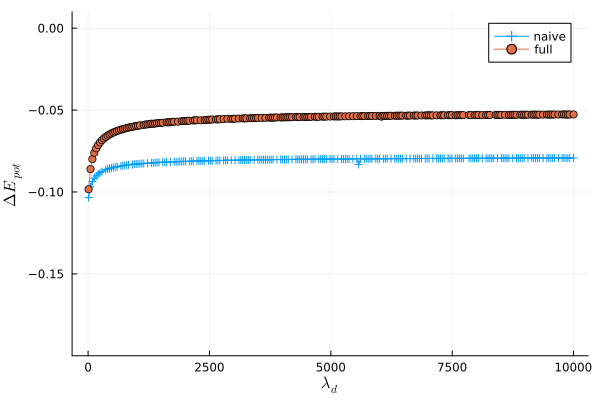

In [219]:
Plots.plot(xr_naive, yr_naive,markershape=:auto, label="naive", xlabel=L"\lambda_d", ylabel=L"\Delta E_{pot}",ylims=(-0.2,0.01))
Plots.plot!(xr_full, yr_full,markershape=:auto, label="full")

In [129]:
f = jldopen(joinpath(dataDir,"lDGA_$(lDGAhelper.kG.Ns).jld2"),"w")
f["chi_m"] = χm_nl
f["chi_d"] = χd_nl
f["gamma_m"] = γm_nl
f["gamma_d"] = γd_nl
f["EPot_Cond_Full_x"] = xr_full
f["EPot_Cond_Full_y"] = yr_full
f["EPot_Cond_Plain_x"] = xr_naive
f["EPot_Cond_Plain_y"] = yr_naive
close(f)

┌ Warning: Attempting to store LadderDGA.LambdaCorrection.var"#f!#3".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Atomt\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447


In [164]:
Plots.savefig(joinpath(dataDir,"cond_curve_mu1.62_Nk$(lDGAhelper.kG.Ns)_nb5_large2.pdf"))

"G:\\Hamburg\\compressibility\\b44.0U2.64_mu1.59_nb5_large2\\cond_curve_mu1.62_Nk10_nb5_large2.pdf"

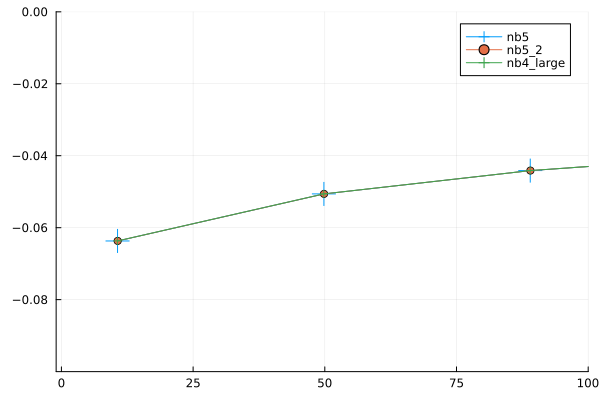

In [227]:
Plots.plot(xr_nb5_large_full, yr_nb5_large_full,markershape=:auto, markersize=12, label="nb5",ylims=(-0.1,0.0), xlims=(-1,100))
Plots.plot!(xr_nb5_large2_full, yr_nb5_large2_full,markershape=:auto, label="nb5_2")
Plots.plot!(xr_nb4_large_full, yr_nb5_large2_full,markershape=:auto, label="nb4_large")

In [220]:
xr_nb4_large_full=deepcopy(xr_full)
yr_nb4_large_full=deepcopy(yr_full)

200-element Vector{Float64}:
 NaN
  -0.09831348073404117
  -0.0860150939900235
  -0.07989995520154555
  -0.07605946940397698
  -0.07335786284257055
  -0.07132355555620418
  -0.0697201953232825
  -0.06841432795448624
  -0.06732407347075345
  -0.0663960089249078
  -0.06559358288901833
  -0.06489082201326099
   ⋮
  -0.0527430149049361
  -0.05273551750355546
  -0.05272818008737326
  -0.05272089438578829
  -0.052713555251200694
  -0.05269801933976722
  -0.052676600106615304
  -0.05264570415031388
  -0.052753239349742145
  -0.05269299875132279
  -0.05267867627552259
  -0.052661342554445066

In [140]:
Φs, Φt = jldopen(joinpath(env.inputDir, "DMFT2_out.jld2"), "r") do f
    f["Φpp_s"], f["Φpp_t"]
end
Φs = permutedims(Φs, [2, 3, 1])
Φt = permutedims(Φt, [2, 3, 1])
Φ_ud = 0.5 .* (Φs .+ Φt)

lDGAhelper_Ur = deepcopy(lDGAhelper)
lDGAhelper_Ur.Γ_m[:, :, :] = lDGAhelper_Ur.Γ_m[:, :, :] .- (-lDGAhelper_Ur.mP.U / lDGAhelper_Ur.mP.β^2)
lDGAhelper_Ur.Γ_d[:, :, :] = lDGAhelper_Ur.Γ_d[:, :, :] .- ( lDGAhelper_Ur.mP.U / lDGAhelper_Ur.mP.β^2)
χm_star_gen = calc_gen_χ(lDGAhelper_Ur.Γ_m, bubble, lDGAhelper_Ur.kG)
χd_star_gen = calc_gen_χ(lDGAhelper_Ur.Γ_d, bubble, lDGAhelper_Ur.kG);

In [141]:
χm_nl_λdm = χ_λ(χm_nl, res_dm.λm)
χd_nl_λdm = χ_λ(χd_nl, res_dm.λd);

In [142]:
Fm_λ0 = LadderDGA.F_from_χ_star_gen(bubble, χm_star_gen, χm_nl, γm_nl, -lDGAhelper.mP.U)
Fd_λ0 = LadderDGA.F_from_χ_star_gen(bubble, χd_star_gen, χd_nl, γd_nl,  lDGAhelper.mP.U);
Fm_λdm = LadderDGA.F_from_χ_star_gen(bubble, χm_star_gen, χm_nl_λdm, γm_nl, -lDGAhelper.mP.U)
Fd_λdm = LadderDGA.F_from_χ_star_gen(bubble, χd_star_gen, χd_nl_λdm, γd_nl,  lDGAhelper.mP.U);

In [143]:
build_kGrid_subsample = LadderDGA.build_kGrid_subsample
Dispersions = LadderDGA.Dispersions
grid_type = LadderDGA.grid_type
grid_dimension = LadderDGA.grid_dimension
build_GG = LadderDGA.build_GG
build_q_access = LadderDGA.build_q_access
Freq_to_OneToIndex = LadderDGA.Freq_to_OneToIndex
freq_inbounds = LadderDGA.freq_inbounds;

In [144]:
μ = lDGAhelper.mP.μ
Σ = lDGAhelper.Σ_loc

max_Nk = lDGAhelper.kG.Nk
GF = lDGAhelper.gLoc
cut_to_non_nan = true
max_ν = 2 #cut_to_non_nan ? trunc(Int, lDGAhelper.sP.n_iν / 2 - 3) : lDGAhelper.sP.n_iν
νnGrid = (-max_ν):(max_ν-1) #-1:0 #-
kG, sub_i = build_kGrid_subsample(lDGAhelper.kG, 10)
println("lDΓA k-grid: ", lDGAhelper.kG, "linearized Eliashberg Eq. k-grid: ", kG)

k_vecs = collect(Dispersions.gen_sampling(grid_type(kG), grid_dimension(kG), kG.Ns))

νlen = length(νnGrid)
klen = length(k_vecs)
ωi_pp = lDGAhelper.sP.n_iω + 1

Fm_loc = LadderDGA.F_from_χ(:m, lDGAhelper)
Fd_loc = LadderDGA.F_from_χ(:d, lDGAhelper)
qi_access = build_q_access(kG, k_vecs[:]);

Brute force checking for possible sub-samples. This needs to be rewritten
lDΓA k-grid: Dispersions.cPnn(t=0.25) grid in 2 dimensions with 100 k-points.linearized Eliashberg Eq. k-grid: Dispersions.cPnn(t=0.25) grid in 2 dimensions with 100 k-points.


In [145]:
Fm_ladder = Fm_λdm;
Fd_ladder = Fd_λdm;
h = lDGAhelper;

In [146]:
function getG_naive(kG, Σ, kp, νp, μ, β)
    ϵk = LadderDGA.Dispersions.gen_ϵkGrid(LadderDGA.Dispersions.grid_type(kG), [kp], kG.t, kG.tp, kG.tpp)[1]
    Σν = νp > -1 ? Σ[νp] : conj(Σ[-νp-1])
    Gk = 1/(1im * (2*νp+1)*π/β + μ - ϵk - Σν)
    return Gk
end

function χ₀_naive(kG, Σ, kp, νp, μ, β)
    Gk = getG_naive(kG, Σ, kp, νp, μ, β)
    G_minusk = getG_naive(kG, Σ, -1 .* kp, -νp-1, μ, β)
    return Gk*G_minusk
end


function build_χ₀pp_vec(Σ, k_vecs, νnGrid, μ, β)
    χ₀_vec = Array{ComplexF64,1}(undef, length(k_vecs) * length(νnGrid))

    for (νpi, νpn) in enumerate(νnGrid)
        for (kpi, kp_vec) in enumerate(k_vecs)
            χ₀_vec[kpi+length(k_vecs)*(νpi-1)] = χ₀_naive(kG, Σ, kp_vec, νpn, μ, β)
        end
    end
    return χ₀_vec
end

#χ₀_vec = build_χ₀pp_vec(lDGAhelper.Σ_loc, k_vecs, νnGrid, μ, β);

build_χ₀pp_vec (generic function with 1 method)

In [147]:
Γs_ladder1 = nothing
GC.gc()

In [ ]:
Γs_ladder1 = Array{ComplexF64,2}(undef, νlen * klen, νlen * klen)
Γs_ladder_test1 = Array{Tuple{},2}(undef, νlen * klen, νlen * klen)
fill!(Γs_ladder1, NaN + 1im * NaN);
Fph_ladder_updo = permutedims(-1.5 .* Fm_ladder[:, :, sub_i, :].+ 0.5 .* Fd_ladder[:, :, sub_i, :], [3, 1, 2, 4]) .- reshape(0.5 .* Fd_loc .- 0.5 .* Fm_loc, 1, size(Fd_loc)...)

for (νi, νn) in enumerate(νnGrid)
    for (νpi, νpn) in enumerate(νnGrid)
        ν_minus_νp = νn - νpn            # 2m = (2n+1) - (2n' + 1) => m = n-n'
        νp_minus_ν = νpn - νn
        minus_ν_minus_νp = -νn - νpn - 1 # 2m = -(2n+1) - (2n' + 1) => m = -n-n'-1
        minus_ν = -νn - 1                # 2n'+1 = -(2n+1) => n' = -n - 1
        minus_νp = -νpn - 1 
        ν_plus_νp = νn + νpn + 1         # 2m = (2n+1) + (2n' + 1) => m = n+n'+1
        νi_pp = νn + lDGAhelper.sP.n_iν + 1
        νpi_pp = νpn + lDGAhelper.sP.n_iν + 1

        ωi_ladder, νi_ladder, νpi_ladder = Freq_to_OneToIndex(ν_minus_νp, νpn, minus_ν, h.sP.shift, h.sP.n_iω, h.sP.n_iν)
        if freq_inbounds(ωi_ladder, νi_ladder, νpi_ladder, h.sP)
            for (ki, k_vec) in enumerate(k_vecs)
                for (kpi, kp_vec) in enumerate(k_vecs)
                    qi = qi_access[ki, kpi]
                    Γs_ladder1[νi+νlen*(ki-1), νpi+νlen*(kpi-1)] =
                        #-(Fph_ladder_updo[qi, νi_ladder, νpi_ladder, ωi_ladder] .- Φ_ud[νi_pp, νpi_pp, ωi_pp]) * χ₀_naive(kG, Σ, kp_vec, νpn, μ, h.mP.β) / (lDGAhelper.kG.Nk * lDGAhelper.mP.β)
                end
            end
        end
    end
end

In [107]:
using LinearAlgebra,Arpack

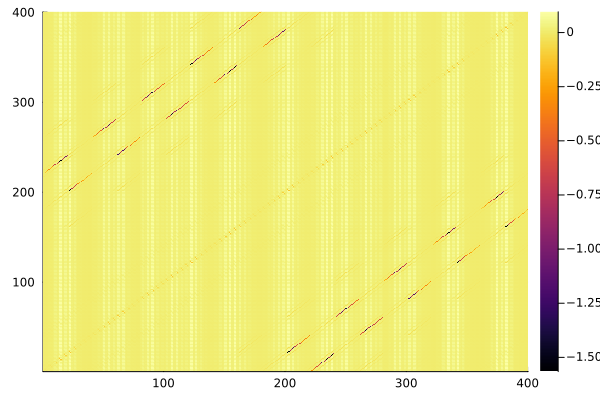

In [111]:
Plots.heatmap(real(Γs_ladder1))

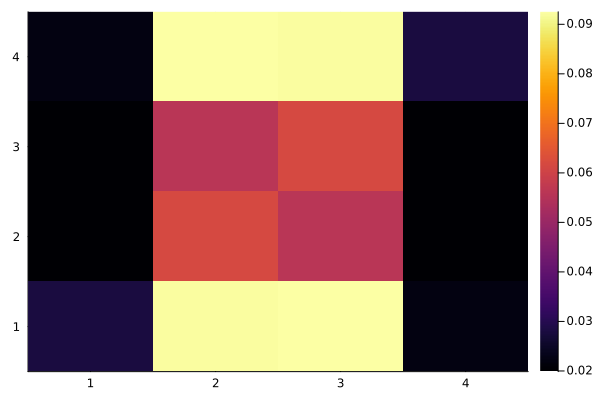

In [108]:
ti = 0
tpi = 5
Plots.heatmap(real(Γs_ladder1[(ti*νlen+1):((ti+1)*νlen),(tpi*νlen+1):((tpi+1)*νlen)] ))

In [109]:
λ1L, _, _, _, _, _ = eigs(Γs_ladder1; nev = 2, which = :LR, tol = 1e-18)

(ComplexF64[7.806183067074341 - 2.3050391177381857e-6im, 2.0404327702151406 + 1.893872635924232e-6im], ComplexF64[0.01716190632809221 - 0.058133881253505444im 1.1546274212620064e-17 - 1.6018918281117142e-17im; 0.012019889924349953 - 0.040715921326291815im -2.3374421590376825e-18 - 2.2781713108046376e-19im; … ; 0.0123901236156439 - 0.041970023443297824im 2.096772617231041e-17 - 7.51665248255818e-18im; 0.017571409288312436 - 0.05952100122395189im -3.380823123175428e-19 + 3.3576854567657485e-17im], 2, 5, 89, ComplexF64[0.030711116037906164 + 0.02897901942358068im, 0.03429517652254912 + 0.008030241105090073im, 0.030802207218052647 + 0.01088319180257446im, -0.03500547920274212 + 0.00996301521570263im, -0.02781588937867247 + 0.010247331947075085im, 0.03489211980104876 + 0.009600109697361291im, 0.0546494508804974 + 0.004848342376580623im, 1.948342612742986e-5 + 0.04202177269461966im, 0.005288100341416714 - 0.032845195557782786im, -0.03117980992563189 + 0.025051260847652388im  …  0.01839523853

In [110]:
λ1S, _, _, _, _, _ = eigs(Γs_ladder1; nev = 2, which = :SR, tol = 1e-18)

(ComplexF64[-1.9527276339775652 - 2.436496580830982e-6im, -1.9133571136941097 - 2.019470251807147e-6im], ComplexF64[0.05590491466933747 + 0.0025631291701637806im -0.00016997531249433976 - 0.0013641955051689916im; 0.008318295760266142 + 0.0003813451840408278im -0.00017565929059537084 - 0.0014098313213238758im; … ; 0.008774931605883565 + 0.0004022973060333702im -3.0231213803041517e-16 - 2.301346658715511e-16im; 0.0519076538516924 + 0.002379879906514924im -1.7206978069961837e-15 - 1.4317994336843049e-15im], 2, 7, 127, ComplexF64[0.008006607140939037 + 0.004931955232668589im, -0.028723346105325603 + 0.02387352674918154im, 0.02881036846214838 - 0.015237908349709261im, 0.004857360100634305 - 0.007669106108771093im, 0.02977255755156592 + 0.014391844513239006im, -0.00011362729370738357 + 0.0016199560609939335im, -0.0018252317290286743 + 0.0037037098279219115im, -0.005893759158066481 + 0.0008682081303825626im, -0.017213437930656272 - 0.009540153517415034im, 0.016399203696977355 + 0.009459425966

In [90]:
λ1L, _, _, _, _, _ = eigs(Γs_ladder1; nev = 2, which = :LR, tol = 1e-18)

(ComplexF64[1.2503234011531803 + 1.4481062406188841e-6im, 1.0320255020813185 + 1.717103912865775e-6im], ComplexF64[1.6653345369377348e-16 + 6.938893903907228e-17im 1.6653345365420792e-16 - 3.469446947510718e-17im; -1.6653345369377348e-16 - 8.326672684688674e-17im -3.60822482959285e-16 - 1.1102230250544968e-16im; … ; -1.0408340855860843e-16 - 1.1102230246251565e-16im 1.5959455983568053e-16 - 5.551115125173818e-17im; 2.7755575615628914e-17 - 1.3877787807814457e-17im -4.718447854643561e-16 - 2.0816681710707134e-16im], 2, 1, 8, ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])

In [43]:
λ1S, _, _, _, _, _ = eigs(Γs_ladder1; nev = 2, which = :SR, tol = 1e-18)

(ComplexF64[-5.87444238385325 - 2.344706592868895e-6im, -3.9546542882709965 + 9.02647681699168e-7im], ComplexF64[-0.0001526421105507104 - 0.0009019434080445023im -0.0028032483253072693 + 0.0017079254802248559im; -0.00016703418595593228 - 0.0009869836047289506im -0.003034718317015948 + 0.0018489511095154585im; … ; -0.00016679500334865872 - 0.0009855705941021807im -0.003030416989477825 + 0.0018463264587512372im; -0.00015245377863178745 - 0.0009008304396173825im -0.002799885386224095 + 0.0017058730424568144im], 2, 3, 55, ComplexF64[0.004295879305014086 + 0.0010745280432870633im, -0.0014921817699786806 - 0.004603073509664289im, -0.00011829114011748932 + 0.00407436621183421im, -0.0004535103838156198 + 0.00030636678823102095im, 0.00020881645482771102 + 0.004230706888059221im, -0.0008849985350484741 - 0.003455912425804029im, 0.0018006529987933035 + 0.005053664844549968im, 0.0010836522625301596 - 0.0007766805729970225im, -0.004640834733967037 - 0.0023629820912932724im, -0.0013488745155492633 -

In [80]:
Γs1 = calc_Γs_ud_nb(Fm_λdm, Fd_λdm, Φ_ud, lDGAhelper, lDGAhelper.gLoc; max_Nk = 4)
λ1L, _, _, _, _, _ = eigs(Γs1; nev = 1, which = :LR, tol = 1e-18)
λ1S, _, _, _, _, _ = eigs(Γs1; nev = 1, which = :SR, tol = 1e-18)

LoadError: UndefVarError: `calc_Γs_ud_nb` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [81]:
println("EV: Larges $λ1L smalles $λ1S")

EV: Larges ComplexF64[NaN + NaN*im, NaN + NaN*im] smalles ComplexF64[NaN + NaN*im, NaN + NaN*im]


In [33]:
λ1L, λ1S = calc_λmax_linEliashberg(bubble, χm_nl, χd_nl, γm_nl, γd_nl, lDGAhelper, env; GF = lDGAhelper.gLoc, max_Nk = 4)

LoadError: KeyError: key "Φpp_s" not found

In [34]:
    Γs1 = calc_Γs_ud(Fm, Fd, Phi_ud, h, GF; max_Nk = max_Nk)
    λ1L, _, _, _, _, _ = eigs(Γs1; nev = 1, which = :LR, tol = 1e-18)
    λ1S, _, _, _, _, _ = eigs(Γs1; nev = 1, which = :SR, tol = 1e-18)
    return λ1L, λ1S

LoadError: UndefVarError: `Phi_ud` not defined in `Main`
Suggestion: check for spelling errors or missing imports.